In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [81]:
from tqdm.autonotebook import tqdm
tqdm.pandas()

In [1]:
base_dir = '/kaggle/input/landmark-recognition-2020'

Analyze training dataset

In [11]:
train = pd.read_csv(os.path.join(base_dir,'train.csv'))

In [13]:
train.head()

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7


In [15]:
train.duplicated().sum()

0

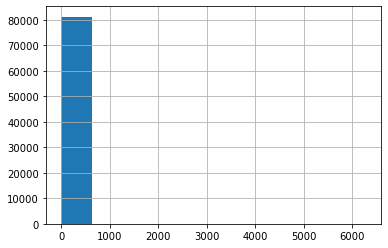

In [16]:
train['landmark_id'].value_counts().hist()


In [17]:
# missing data in training data 
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending = False)
missing_train_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head()

,Total,Percent
landmark_id,0,0.0
id,0,0.0


In [27]:
temp_data= pd.DataFrame(train['landmark_id'].value_counts().head(10)).reset_index()

In [29]:
temp_data.columns=['landmark_id','count']

In [22]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
import glob
warnings.filterwarnings('ignore')

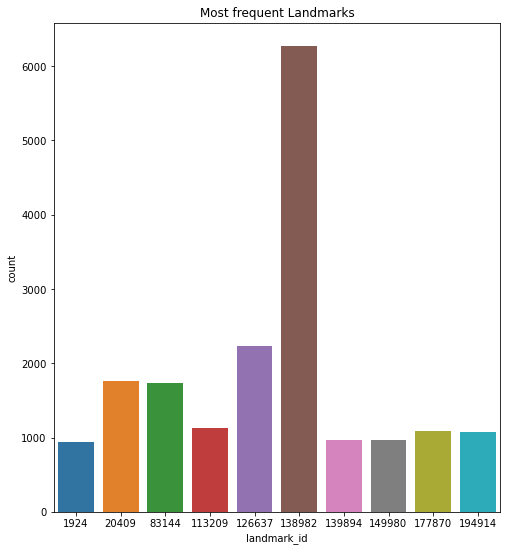

In [31]:
plt.figure(figsize=(8,9))
plt.title('Most frequent Landmarks')
sns.set_color_codes("pastel")
sns.barplot(x="landmark_id", y="count", data=temp_data,
            label="Count")
plt.show()

In [32]:
# Occurance of landmark_id in increasing order
temp = pd.DataFrame(train.landmark_id.value_counts().tail(8))
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']
temp

,landmark_id,count
0,4171,2
1,73532,2
2,195143,2
3,180503,2
4,179834,2
5,183115,2
6,63266,2
7,197219,2


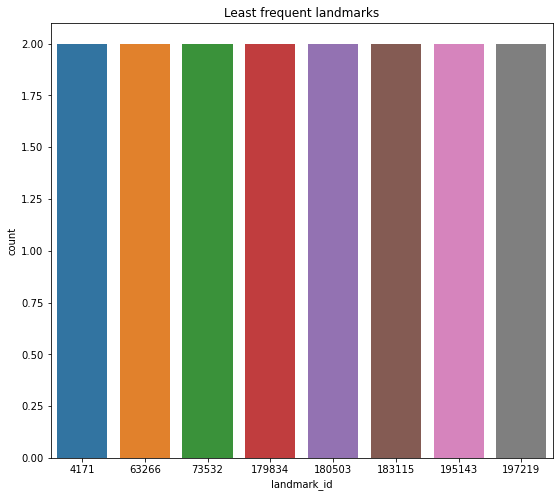

In [33]:
# Plot the least frequent landmark_ids
plt.figure(figsize = (9, 8))
plt.title('Least frequent landmarks')
sns.set_color_codes("pastel")
sns.barplot(x="landmark_id", y="count", data=temp,
            label="Count")
plt.show()

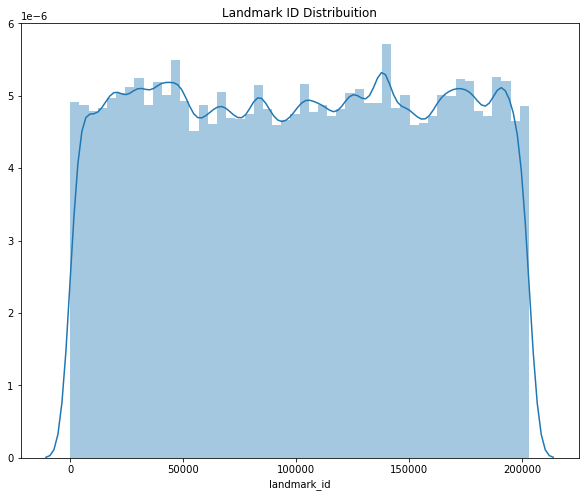

In [34]:
#Landmark ID distribution
plt.figure(figsize = (10, 8))
plt.title('Landmark ID Distribuition')
sns.distplot(train['landmark_id'])

plt.show()

In [35]:
print("Number of classes under 20 occurences",(train['landmark_id'].value_counts() <= 20).sum(),'out of total number of categories',len(train['landmark_id'].unique()))

Number of classes under 20 occurences 61620 out of total number of categories 81313


In [36]:
train_list = glob.glob(os.path.join(base_dir,'train/*/*/*/*'))

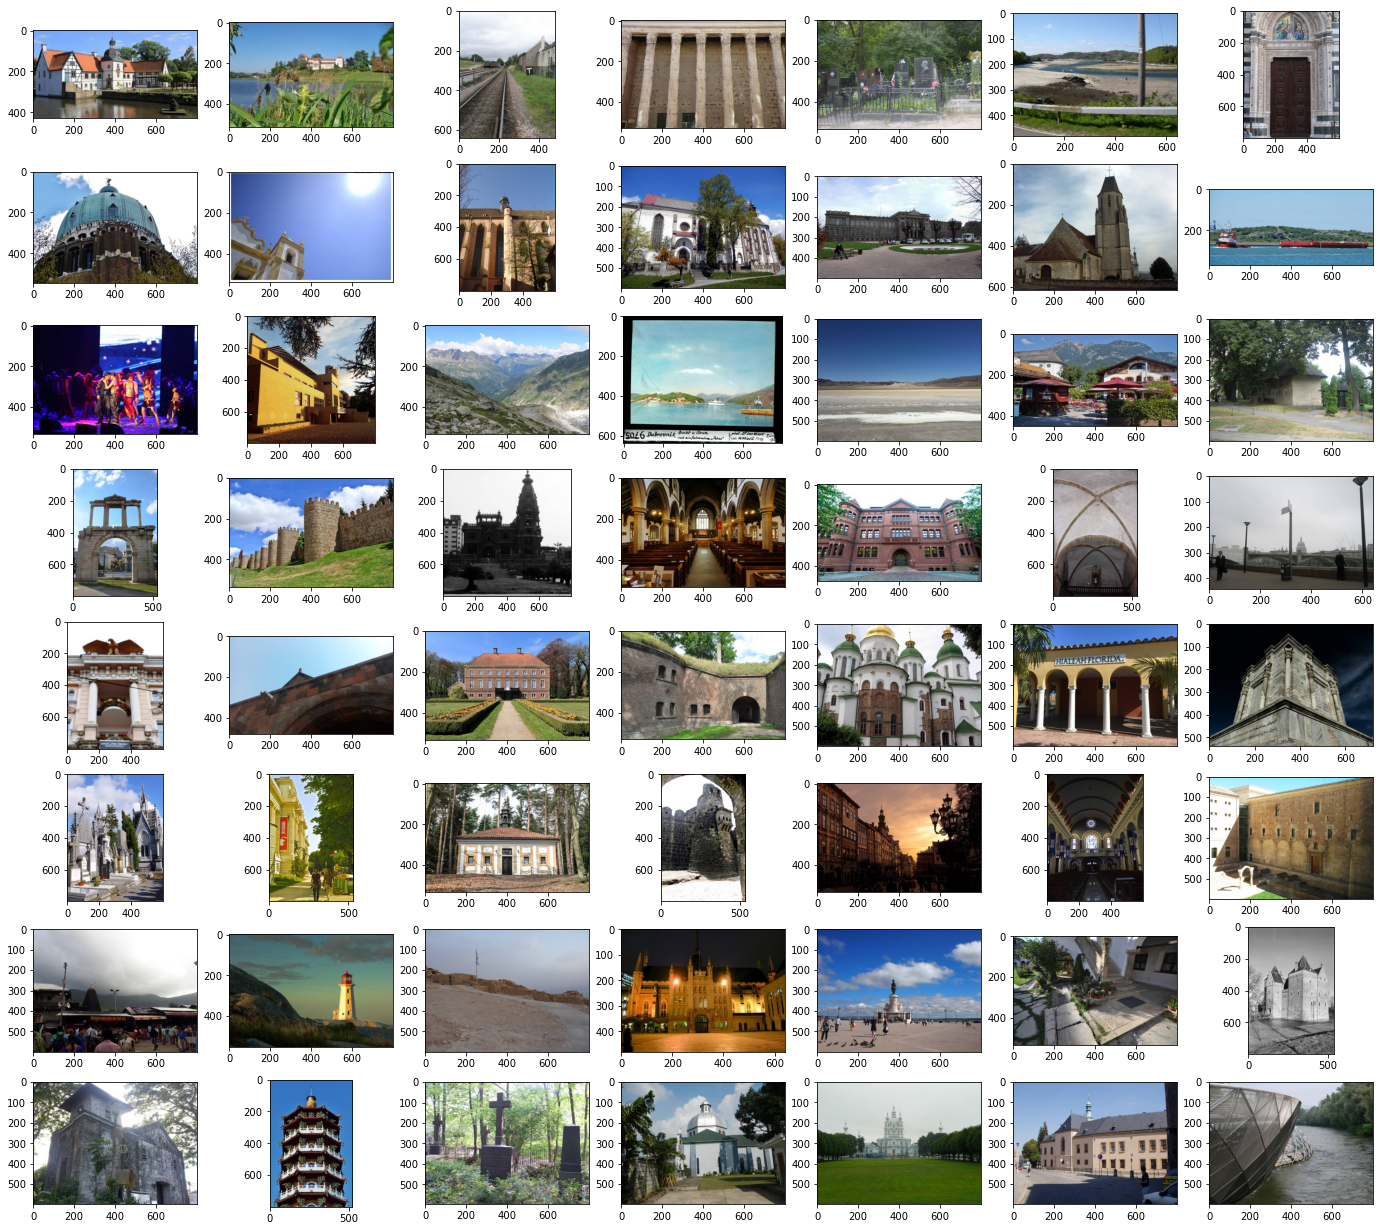

In [41]:
plt.rcParams["axes.grid"] = False
f, axarr = plt.subplots(8, 7, figsize=(24, 22))

curr_row = 0
for i in range(56):
    example = cv2.imread(train_list[i])
    example = example[:,:,::-1]
    
    col = i%8
    axarr[col, curr_row].imshow(example)
    if col == 7 :
        curr_row += 1

In [48]:
sample_train = train[train['landmark_id'].isin(temp_data['landmark_id'])].reset_index(drop = True)

In [49]:
sample_train

,id,landmark_id
0,00061e23ce736fa9,1924
1,0060992db5cc819f,1924
2,008315aa634e14b9,1924
3,008e6817cf364cb6,1924
4,00bad7a508ee6666,1924
...,...,...
18174,fe39ecfef87aba10,194914
18175,feab23b7043d5f8f,194914
18176,ff36f95c461055da,194914
18177,ffdc4dbe323941de,194914


In [51]:
train.landmark_id.nunique()

81313

In [52]:
sample_train.landmark_id.nunique()

10

In [53]:
import shutil

In [55]:
landmark_id = list(sample_train.landmark_id.unique())

In [63]:
def create_folder_structure(base_dir,landmark_id, mode="train"):
    """
    :param output_dir:
    :param mode:
    :return:
    """
    base_dir = base_dir + "/" + mode
    if os.path.exists(base_dir):
        shutil.rmtree(base_dir)
    os.makedirs(base_dir)
    for id_ in landmard_id:
        os.makedirs(base_dir + "/" + str(id_)) 
    return base_dir

****Create folder structure for sample dataset****

In [66]:
output_dir = '/kaggle/working'
train_dir = create_folder_structure(output_dir,landmark_id,mode='train')
validation_dir = create_folder_structure(output_dir,landmark_id,mode='validation')

In [100]:
def get_file_path(input_dir,path_id,mode='train'):
    prefix = path_id[:3]
    path = input_dir + "/" + mode + "/" +"{0}/{1}/{2}/".format(prefix[0],prefix[1],prefix[2])
    filename = path_id
    return path + filename + ".jpg"
    

In [102]:
def copy(dataframe,output_dir,id_,mode='train'):
    destination = output_dir + "/" + mode + "/" + str(id_)
    for index,row in dataframe.iterrows():
        shutil.copy(row['file_path'],destination)

In [106]:
def copy_files(input_dir,output_dir,dataframe,landmark_id):
    for id_ in tqdm(landmark_id):
        print('Landmark with id: {}'.format(id_))
        temp = dataframe[sample_train['landmark_id']==id_]
        train = temp.sample(frac = 0.8,random_state = 1)
        validation = temp[~temp['id'].isin(train.id)]
        train['file_path'] = train.apply(lambda x: get_file_path(input_dir,x['id'],mode = 'train'),axis =1)
        validation['file_path'] = validation.apply(lambda x: get_file_path(input_dir,x['id'],mode = 'train'),axis =1)
        # Copy training files
        copy(train,output_dir,id_,mode = 'train')
        # Copy validation files
        copy(validation,output_dir,id_,mode = 'validation')
    
    

In [108]:
copy_files(base_dir,output_dir,sample_train,landmark_id)

Landmark with id: 1924
Landmark with id: 20409
Landmark with id: 83144
Landmark with id: 113209
Landmark with id: 126637
Landmark with id: 138982
Landmark with id: 139894
Landmark with id: 149980
Landmark with id: 177870
Landmark with id: 194914



In [115]:
sample_train_list = glob.glob(os.path.join(output_dir,'train/*/*'))
sample_validation_list = glob.glob(os.path.join(output_dir,'validation/*/*'))

In [117]:
print('Number of training images: {}'.format(len(sample_train_list))+"\n" + "Number of validation images: {}".format(len(sample_validation_list)))

Number of training images: 14543
Number of validation images: 3636


In [118]:
from zipfile import ZipFile
import os
from os.path import basename
# create a ZipFile object
with ZipFile('/kaggle/working/sample_google_landmark_retrieval.zip', 'w') as zipObj:
   # Iterate over all the files in directory
   for folderName, subfolders, filenames in os.walk(output_dir):
        for filename in filenames:
           #create complete filepath of file in directory
           filePath = os.path.join(folderName, filename)
           # Add file to zip
           zipObj.write(filePath, basename(filePath))

In [128]:
import datetime
def print_info(archive_name):
    zf = ZipFile(archive_name)
    size = sum([zinfo.file_size for zinfo in  zf.filelist])
    zip_mb = float(size)/1000000 #MB
    print('Archive size: {}'.format(zip_mb))


In [129]:
print_info(archive_name=os.path.join(output_dir,'sample_google_landmark_retrieval.zip'))

Archive size: 1223.144895


****Generate Download Link****

In [130]:
from IPython.display import FileLink
FileLink(r'sample_google_landmark_retrieval.zip')

/kaggle/working/sample_google_landmark_retrieval.zip